## Core Idea

Despite a lot of creeping Physics and Chemistry knowledge introduced in the description, this competition is more about Geometry and pattern matching.

The hypothesis of this kernel is next:
1. If we have two similar sets of atoms with the same distances between them and the same types - the scalar coupling constant should be very close.
2. More closest atoms to the pair of atoms under prediction have higher influence on scalar coupling constant then those with higher distance

So, basically, this problem could be dealt with some kind of K-Nearest Neighbor algorithm or any tree-based - e.g. LightGBM, in case we can find some representation which would describe similar configurations with similar feature sets.

Each atom is described with 3 cartesian coordinates. This representation is not stable. Each coupling pair is located in a different point in space and two similar coupling sets would have very different X,Y,Z.

So, instead of using coordinates let's consider next system:
1. Take each pair of atoms as two first core atoms
2. Calculate the center between the pair
3. Find all n-nearest atoms to the center (excluding first two atoms)
4. Take two closest atoms from step 3 - they will be 3rd and 4th core atoms
5. Calculate the distances from 4 core atoms to the rest of the atoms and to the core atoms as well

Using this representation each atom position can be described by 4 distances from the core atoms. This representation is stable to rotation and translation. And it's suitable for pattern-matching. So, we can take a sequence of atoms, describe each by 4 distances + atom type(H,O,etc) and looking up for the same pattern we can find similar configurations and detect scalar coupling constant.

Here I used LightGBM, because sklearn KNN can't deal with the amount of data. My blind guess is that hand-crafted KNN can outperform LightGBM.

Let's code the solution!

## Import modules, set options

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import math
import gc
import copy

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMRegressor
import os
# os.listdir('../input/imputed')

In [2]:
DATA_PATH = '..\\input'
SUBMISSIONS_PATH = '..\\output'
INPUT_ADDED = '..\\input_added'
# use atomic numbers to recode atomic names
ATOMIC_NUMBERS = {
    'H': 1,
    'C': 6,
    'N': 7,
    'O': 8,
    'F': 9
}

In [3]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 120)
pd.set_option('display.max_columns', 120)

## Load Dataset

By default all data is read as `float64` and `int64`. We can trade this uneeded precision for memory and higher prediction speed. So, let's read with Pandas all the data in the minimal representation: 

In [4]:
train_dtypes = {
    'molecule_name': 'category',
    'atom_index_0': 'int8',
    'atom_index_1': 'int8',
    'type': 'category',
    'scalar_coupling_constant': 'float32'
}
train_csv = pd.read_csv(f'{DATA_PATH}\\train.csv', index_col='id', dtype=train_dtypes)
train_csv['molecule_index'] = train_csv.molecule_name.str.replace('dsgdb9nsd_', '').astype('int32')
train_csv = train_csv[['molecule_index', 'atom_index_0', 'atom_index_1', 'type', 'scalar_coupling_constant']]
train_csv.head(10)

C:\ProgramFiles\Anaconda\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,molecule_index,atom_index_0,atom_index_1,type,scalar_coupling_constant
id,,,,,
0,1,1,0,1JHC,84.807602
1,1,1,2,2JHH,-11.257000
2,1,1,3,2JHH,-11.254800
3,1,1,4,2JHH,-11.254300
4,1,2,0,1JHC,84.807404
5,1,2,3,2JHH,-11.254100
6,1,2,4,2JHH,-11.254800
7,1,3,0,1JHC,84.809303
8,1,3,4,2JHH,-11.254300


#### Filter

In [5]:
train_csv, _ = train_test_split(train_csv, test_size=0.99, random_state=42)

#### Train_CSV Params

In [6]:
train_csv.describe()

,molecule_index,atom_index_0,atom_index_1,scalar_coupling_constant
count,46581.000000,46581.000000,46581.000000,46581.000000
mean,69273.949014,13.340826,5.897684,15.642241
std,36548.516161,3.261315,5.001572,34.728249
min,7.000000,2.000000,0.000000,-24.501900
25%,39222.000000,11.000000,2.000000,-0.288595
50%,71690.000000,13.000000,5.000000,2.245890
75%,100777.000000,16.000000,8.000000,7.274130
max,133884.000000,28.000000,26.000000,201.477997


In [7]:
print('Shape: ', train_csv.shape)
print('Total: ', train_csv.memory_usage().sum())
train_csv.memory_usage()

Shape:  (46581, 5)
Total:  885423


Index                       372648
molecule_index              186324
atom_index_0                46581 
atom_index_1                46581 
type                        46965 
scalar_coupling_constant    186324
dtype: int64

In [8]:
submission_csv = pd.read_csv(f'{DATA_PATH}\\sample_submission.csv', index_col='id')

C:\ProgramFiles\Anaconda\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [9]:
test_csv = pd.read_csv(f'{DATA_PATH}\\test.csv', index_col='id', dtype=train_dtypes)
test_csv['molecule_index'] = test_csv['molecule_name'].str.replace('dsgdb9nsd_', '').astype('int32')
test_csv = test_csv[['molecule_index', 'atom_index_0', 'atom_index_1', 'type']]
test_csv.head(10)

,molecule_index,atom_index_0,atom_index_1,type
id,,,,
4658147,4,2,0,2JHC
4658148,4,2,1,1JHC
4658149,4,2,3,3JHH
4658150,4,3,0,1JHC
4658151,4,3,1,2JHC
4658152,15,3,0,1JHC
4658153,15,3,2,3JHC
4658154,15,3,4,2JHH
4658155,15,3,5,2JHH


In [10]:
structures_dtypes = {
    'molecule_name': 'category',
    'atom_index': 'int8',
    'atom': 'category',
    'x': 'float32',
    'y': 'float32',
    'z': 'float32'
}
structures_csv = pd.read_csv(f'{DATA_PATH}\\structures.csv', dtype=structures_dtypes)
structures_csv['molecule_index'] = structures_csv.molecule_name.str.replace('dsgdb9nsd_', '').astype('int32')
structures_csv = structures_csv[['molecule_index', 'atom_index', 'atom', 'x', 'y', 'z']]
structures_csv['atom'] = structures_csv['atom'].replace(ATOMIC_NUMBERS).astype('int8')
structures_csv.head(10)

,molecule_index,atom_index,atom,x,y,z
0,1,0,6,-0.012698,1.085804,0.008001
1,1,1,1,0.002150,-0.006031,0.001976
2,1,2,1,1.011731,1.463751,0.000277
3,1,3,1,-0.540815,1.447527,-0.876644
4,1,4,1,-0.523814,1.437933,0.906397
5,2,0,7,-0.040426,1.024108,0.062564
6,2,1,1,0.017257,0.012545,-0.027377
7,2,2,1,0.915789,1.358745,-0.028758
8,2,3,1,-0.520278,1.343532,-0.775543
9,3,0,8,-0.034360,0.977540,0.007602


In [11]:
print('Shape: ', structures_csv.shape)
print('Total: ', structures_csv.memory_usage().sum())
structures_csv.memory_usage()

Shape:  (2358657, 6)
Total:  42455906


Index             80     
molecule_index    9434628
atom_index        2358657
atom              2358657
x                 9434628
y                 9434628
z                 9434628
dtype: int64

## Build Distance Dataset

### Functions

In [12]:
def build_type_dataframes(base, structures, coupling_type):
    base = base[base['type'] == coupling_type].drop('type', axis=1).copy()
    base = base.reset_index()
    base['id'] = base['id'].astype('int32')
    structures = structures[structures['molecule_index'].isin(base['molecule_index'])]
    return base, structures

In [13]:
def add_coordinates(base, structures, index):
    df = pd.merge(base, structures, how='inner',
                  left_on=['molecule_index', f'atom_index_{index}'],
                  right_on=['molecule_index', 'atom_index']).drop(['atom_index'], axis=1)
    df = df.rename(columns={
        'atom': f'atom_{index}',
        'x': f'x_{index}',
        'y': f'y_{index}',
        'z': f'z_{index}'
    })
    return df

In [14]:
def add_atoms(base, atoms):
    df = pd.merge(base, atoms, how='inner',
                  on=['molecule_index', 'atom_index_0', 'atom_index_1'])
    return df

In [15]:
def merge_all_atoms(base, structures):
    df = pd.merge(base, structures, how='left',
                  left_on=['molecule_index'],
                  right_on=['molecule_index'])
    df = df[(df.atom_index_0 != df.atom_index) & (df.atom_index_1 != df.atom_index)]
    return df

In [16]:
def add_center(df):
    df['x_c'] = ((df['x_1'] + df['x_0']) * np.float32(0.5))
    df['y_c'] = ((df['y_1'] + df['y_0']) * np.float32(0.5))
    df['z_c'] = ((df['z_1'] + df['z_0']) * np.float32(0.5))



def add_distance_between(df, suffix1, suffix2):
    df[f'd_{suffix1}_{suffix2}'] = ((
        (df[f'x_{suffix1}'] - df[f'x_{suffix2}'])**np.float32(2) +
        (df[f'y_{suffix1}'] - df[f'y_{suffix2}'])**np.float32(2) + 
        (df[f'z_{suffix1}'] - df[f'z_{suffix2}'])**np.float32(2)
    )**np.float32(0.5))

In [17]:
def add_distances(df):
    n_atoms = 1 + max([int(c.split('_')[1]) for c in df.columns if c.startswith('x_')])
    
    for i in range(1, n_atoms):
        for vi in range(min(4, i)):
            add_distance_between(df, i, vi)

In [18]:
def add_n_atoms(base, structures):
    dfs = structures['molecule_index'].value_counts().rename('n_atoms').to_frame()
    return pd.merge(base, dfs, left_on='molecule_index', right_index=True)

In [19]:
def build_couple_dataframeOld(some_csv, structures_csv, coupling_type, n_atoms=10):
    base, structures = build_type_dataframes(some_csv, structures_csv, coupling_type)
    base = add_coordinates(base, structures, 0)
    base = add_coordinates(base, structures, 1)
    
    base = base.drop(['atom_0', 'atom_1'], axis=1)
    atoms = base.drop('id', axis=1).copy()
    if 'scalar_coupling_constant' in some_csv:
        atoms = atoms.drop(['scalar_coupling_constant'], axis=1)
        
    add_center(atoms)
    
    
    atoms = atoms.drop(['x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1'], axis=1)

    atoms = merge_all_atoms(atoms, structures)
    
    add_distance_to_center(atoms)
    
    atoms = atoms.drop(['x_c', 'y_c', 'z_c', 'atom_index'], axis=1)
    atoms.sort_values(['molecule_index', 'atom_index_0', 'atom_index_1', 'd_c'], inplace=True)
    atom_groups = atoms.groupby(['molecule_index', 'atom_index_0', 'atom_index_1'])
    atoms['num'] = atom_groups.cumcount() + 2
    atoms = atoms.drop(['d_c'], axis=1)
    atoms = atoms[atoms['num'] < n_atoms]

    atoms = atoms.set_index(['molecule_index', 'atom_index_0', 'atom_index_1', 'num']).unstack()
    atoms.columns = [f'{col[0]}_{col[1]}' for col in atoms.columns]
    atoms = atoms.reset_index()
    
    # downcast back to int8
    for col in atoms.columns:
        if col.startswith('atom_'):
            atoms[col] = atoms[col].fillna(0).astype('int8')
            
    atoms['molecule_index'] = atoms['molecule_index'].astype('int32')
    
    full = add_atoms(base, atoms)
    add_distances(full)
    
    full.sort_values('id', inplace=True)
    
    return full

In [20]:
def take_n_atoms(df, n_atoms, four_start=4):
    labels = []
    for i in range(2, n_atoms):
        label = f'atom_{i}'
        labels.append(label)

    for i in range(n_atoms):
        num = min(i, 4) if i < four_start else 4
        for j in range(num):
            labels.append(f'd_{i}_{j}')
    if 'scalar_coupling_constant' in df:
        labels.append('scalar_coupling_constant')
    output = df[labels]
    atoms_names = list([col for col in output if col.startswith('atom_')])[2:]
    output = output.drop(atoms_names, axis=1)
    return output

In [21]:
def map_atom_info(df, atom_idx):
    structures = structures_csv[['molecule_index', 'atom_index', 'atom']]
    structures = structures_csv
    df = pd.merge(df, structures, how = 'left',
                  left_on  = ['molecule_index', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_index',  'atom_index'])
    df = df.rename(columns={'atom': f'atom_{atom_idx}'});
    #df = df.drop('atom_index', axis=1)    
    return df

### Проверяем, что для каждого типа молекулы только  atom_1 принимает только одно значение

In [22]:
invest0 = map_atom_info(train_csv, 1)
invest0 = invest0[['type','atom_1']]
invest0.groupby(['type']).mean()

,atom_1
type,
1JHC,6
1JHN,7
2JHC,6
2JHH,1
2JHN,7
3JHC,6
3JHH,1
3JHN,7


## Check Regressions for a simple type

## Functions

In [23]:
def add_atoms(base, atoms):
    df = pd.merge(base, atoms, how='inner',
                  on=['molecule_index', 'atom_index_0', 'atom_index_1'])
    return df


def build_atoms(base_from, structures_from, n_atoms):
    base = base_from
    structures = structures_from

    atoms = base.drop('id', axis=1).copy()
    if 'scalar_coupling_constant' in atoms:
        atoms = atoms.drop(['scalar_coupling_constant'], axis=1)

    add_center(atoms)

    atoms = merge_all_atoms(atoms, structures)
        
    add_distance_to_center(atoms)

    atoms.sort_values(['molecule_index', 'atom_index_0', 'atom_index_1', 'd_c'], inplace=True)
    atom_groups = atoms.groupby(['molecule_index', 'atom_index_0', 'atom_index_1'])
    atoms['num'] = atom_groups.cumcount() + 2
    atoms = atoms.drop(['d_c'], axis=1)
    atoms = atoms[atoms['num'] < n_atoms]
    
    atoms = atoms.drop(['x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1'], axis=1)
    atoms = atoms.drop(['atom_index'], axis=1)
    atoms = atoms.set_index(['x_c', 'y_c', 'z_c', 
        'molecule_index', 'atom_index_0', 'atom_index_1', 'num']).unstack()
    atoms.columns = [f'{col[0]}_{col[1]}' for col in atoms.columns]
    atoms = atoms.reset_index()

    # downcast back to int8
    for col in atoms.columns:
        if col.startswith('atom_'):
            atoms[col] = atoms[col].fillna(0).astype('int8')
            
    atoms['molecule_index'] = atoms['molecule_index'].astype('int32')
    
    return atoms


In [24]:
def add_distance_to_center(df):
    df['d_c'] = ((
        ( df['x'] -  df['x_c'])**np.float32(2) +
        ( df['y'] -  df['y_c'])**np.float32(2) + 
        ( df['z'] -  df['z_c'])**np.float32(2)
    )**np.float32(0.5))
    

def cross_prod(v1, v2):
    outp0 = v1[1] * v2[2] - v1[2] * v2[1]
    outp1 = v1[2] * v2[0] - v1[0] * v2[2]
    outp2 = v1[0] * v2[1] - v1[1] * v2[0]
    outp = pd.concat([outp0, outp1,outp2], axis=1)
    return outp


def add_axis_x(df):
    n_x = df.x_0 - df.x_c
    n_y = df.y_0 - df.y_c
    n_z = df.z_0 - df.z_c
    axisFrame = pd.concat([n_x, n_y, n_z], axis=1)
    axisNorm = np.sqrt(np.square(axisFrame).sum(axis=1))
    df['ax_x'] = axisFrame[0] / axisNorm
    df['ax_y'] = axisFrame[1] / axisNorm
    df['ax_z'] = axisFrame[2] / axisNorm


def add_axis_y(df):
    r_vec = pd.concat([df.x_2 - df.x_c, 
                 df.y_2 - df.y_c,
                 df.z_2 - df.z_c], axis=1)
    axis_vec = pd.concat([df['ax_x'], 
                          df['ax_y'], 
                          df['ax_z']], axis=1)
    axis_vec.columns = [0, 1, 2]
    dist =  axis_vec[0] * r_vec[0] + axis_vec[1] * r_vec[1] + axis_vec[2] * r_vec[2]
    yDir = r_vec - axis_vec.multiply(dist, axis="index")
    yDirNorm = np.sqrt(np.square(yDir).sum(axis=1))
    df['ay_x'] = yDir[0] / yDirNorm
    df['ay_y'] = yDir[1] / yDirNorm
    df['ay_z'] = yDir[2] / yDirNorm    

def add_axis_z(df):    
    r_vec = pd.concat([df.x_2 - df.x_c, 
         df.y_2 - df.y_c,
         df.z_2 - df.z_c], axis=1)
    axis_x_vec = pd.concat([df['ax_x'], 
                      df['ax_y'], 
                      df['ax_z']], axis=1)
    axis_x_vec.columns = [0, 1, 2]
    axis_y_vec = pd.concat([df['ay_x'], 
                      df['ay_y'], 
                      df['ay_z']], axis=1)
    axis_y_vec.columns = [0, 1, 2]
    axis_z_vec = cross_prod(axis_x_vec, axis_y_vec)
    df['az_x'] = axis_z_vec[0] 
    df['az_y'] = axis_z_vec[1] 
    df['az_z'] = axis_z_vec[2] 


    
#add coordinates in frame ax,ay,az
def add_r_per_atom(df, suffix):
    x_loc = df[f'x_{suffix}'] - df.x_c
    y_loc = df[f'y_{suffix}'] - df.y_c
    z_loc = df[f'z_{suffix}'] - df.z_c
    r_x =  df['ax_x'] * x_loc + df['ax_y'] * y_loc + df['ax_z'] * z_loc
    r_y =  df['ay_x'] * x_loc + df['ay_y'] * y_loc + df['ay_z'] * z_loc
    r_z =  df['az_x'] * x_loc + df['az_y'] * y_loc + df['az_z'] * z_loc
    df[f'r_x_{suffix}'] = r_x
    df[f'r_y_{suffix}'] = r_y
    df[f'r_z_{suffix}'] = r_z
            
def add_r(df):    
    n_atoms = len([col for col in df if col.startswith('x_')]) - 1
    for i in range(1, n_atoms):
            add_r_per_atom(df, i)
            
def build_couple_dataframe(some_csv, structures_csv, coupling_type, n_atoms=10):
    base, structures = build_type_dataframes(some_csv, structures_csv, coupling_type)
    base = add_coordinates(base, structures, 0)
    base = add_coordinates(base, structures, 1)
    base = base.drop(['atom_0', 'atom_1'], axis=1)
    
    atoms = build_atoms(base, structures, n_atoms)
    df = add_atoms(base, atoms)
    
    add_axis_x(df)
    add_axis_y(df)
    add_axis_z(df)
    add_r(df)

    df.sort_values('id', inplace=True)
    return df


## brute_columns

In [25]:
brute_columns = [
    'molecule_dist_mean',
    'molecule_dist_max',
    'molecule_couples'
    ]

brute_columnsO = [
    'molecule_atom_index_0_dist_max',
    'molecule_atom_index_1_dist_min',
    'molecule_atom_index_0_dist_mean',
    'molecule_atom_index_0_dist_std',
    'molecule_atom_index_1_dist_std',
    'molecule_atom_index_1_dist_max',
    'molecule_atom_index_1_dist_mean',
    'molecule_atom_index_0_dist_max_diff',
    'molecule_atom_index_0_dist_max_div',
    'molecule_atom_index_0_dist_std_diff',
    'molecule_atom_index_1_dist_std_diff',
    'molecule_atom_index_0_dist_mean_div',
    'atom_1_couples_count',
    'molecule_couples',
    'molecule_dist_mean',
    'molecule_atom_index_0_y_1_std',
    'molecule_atom_index_1_dist_min_diff',
    'molecule_atom_index_1_dist_max_div',
    'molecule_atom_index_0_z_1_std',
    'molecule_type_dist_std_diff',
    'molecule_atom_1_dist_min_diff',
    'molecule_atom_index_0_x_1_std',
    'molecule_dist_min',
    'molecule_atom_index_0_y_1_mean_diff',
    'molecule_dist_max',
    'molecule_atom_1_dist_std_diff',
    'molecule_type_dist_max',
    'molecule_atom_index_0_y_1_max_diff',
    'molecule_type_0_dist_std_diff',
    'molecule_type_dist_mean_diff',
    'molecule_atom_1_dist_mean',
    'molecule_atom_index_0_y_1_mean_div',
    ]

In [26]:
def add_distance_between(df, suffix1, suffix2):
    df[f'd_{suffix1}_{suffix2}'] = ((
        (df[f'x_{suffix1}'] - df[f'x_{suffix2}'])**np.float32(2) +
        (df[f'y_{suffix1}'] - df[f'y_{suffix2}'])**np.float32(2) + 
        (df[f'z_{suffix1}'] - df[f'z_{suffix2}'])**np.float32(2)
    )**np.float32(0.5))

In [27]:
def add_distances(df, n_atoms):
    for i in range(1, n_atoms):
        for vi in range(min(4, i)):
            add_distance_between(df, i, vi)    

In [28]:
def take_n_atoms(df, n_atoms, four_start=4):
    labels = []
    for i in range(2, n_atoms):
        label = f'atom_{i}'
        labels.append(label)

    for i in range(1, n_atoms):
        labels.append(f'r_x_{i}')
    for i in range(2, n_atoms):
        labels.append(f'r_y_{i}')
    for i in range(3, n_atoms):
        labels.append(f'r_z_{i}')
    for i in range(n_atoms):
        num = min(i, 4) if i < four_start else 4
        for j in range(num):
            labels.append(f'd_{i}_{j}') 
    labels.remove('d_1_0') 
    if 'scalar_coupling_constant' in df:
        labels.append('scalar_coupling_constant')
    #labels = labels + brute_columns                
    output = df[labels]
    #atoms_names = list([col for col in output if col.startswith('atom_')])[2:]
    #output = output.drop(atoms_names, axis=1)
    return output

## New heading

In [29]:
def build_XY(some_csv, coupling_type, n_atoms, isTest = False):
    #full = build_couple_dataframe(some_csv, structures_csv, coupling_type, n_atoms=n_atoms)
    if isTest:
        full_all = pd.read_csv(f'{INPUT_ADDED}/test_{coupling_type}.csv')
    else:
        full_all =  pd.read_csv(f'{INPUT_ADDED}/{coupling_type}.csv')
    add_distances(full_all,n_atoms)        
    #brute_all =  pd.read_csv(f'{INPUT_ADDED}/brute_X_{coupling_type}.csv')
    #full =  full_all.merge(brute_all, left_on='id', right_on='Unnamed: 0')
    full = full_all

    df = take_n_atoms(full, n_atoms)
    df = df.fillna(0)
    #print(df.columns
    return df
    
def build_x_y_data(df):
    if 'scalar_coupling_constant' in df:
        X_data = df.drop(['scalar_coupling_constant'], axis=1)
        y_data = df['scalar_coupling_constant']
    else:
        X_data = df
        y_data = None
    return X_data, y_data

In [36]:
%%time
coupling_type = '1JHC'
n_atoms = 15
XY_Data = build_XY(train_csv, coupling_type, n_atoms, False)

Wall time: 19.1 s


## Outliers

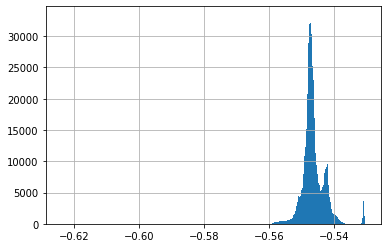

In [85]:
pd.Series(XY_Data.r_x_1).hist(bins = 500)

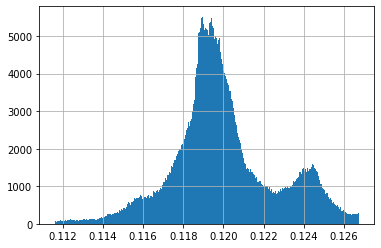

In [99]:
low_r_x_2, up_r_x_1 = np.percentile(XY_Data.r_x_1, [1,97])
XY_Filtered = XY_Data[(XY_Data.r_x_1 < up_r_x_1) & (XY_Data.r_x_1 > low_r_x_2)]
pd.Series(XY_Filtered.r_x_1 + 2/3).hist(bins = 500)
#r_x_1_trunc = np.clip(X_train.r_x_1, up_r_x_1, low_r_x_2)
#pd.Series(r_x_1_trunc).hist(bins = 60)

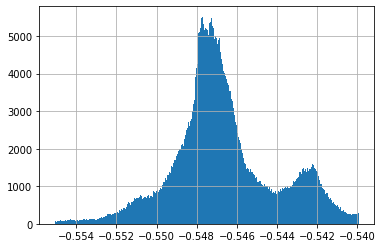

In [110]:
low_r_x_2, up_r_x_1 = np.percentile(XY_Data.r_x_1, [1,97])
XY_Filtered = XY_Data[(XY_Data.r_x_1 < up_r_x_1) & (XY_Data.r_x_1 > low_r_x_2) & (XY_Data.d_3_1 > 0.8)]
pd.Series(XY_Filtered.r_x_1).hist(bins = 500)

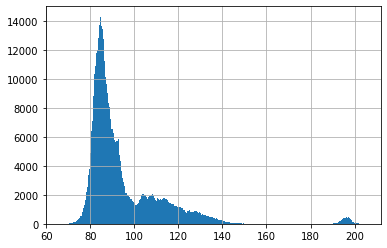

In [105]:
pd.Series(XY_Data.scalar_coupling_constant).hist(bins = 500)

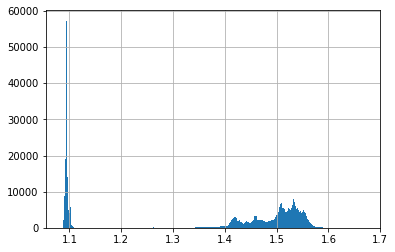

In [112]:
pd.Series(XY_Filtered.d_3_1).hist(bins = 500)

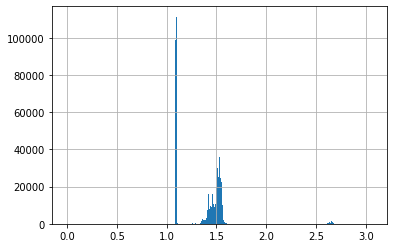

In [114]:
pd.Series(XY_Data.d_3_1).hist(bins = 500) 

## LGBMRegressor

In [148]:
XY_Filtered = XY_Data
X_data, y_data = build_x_y_data(XY_Filtered)
XY_test = build_XY(test_csv, coupling_type, n_atoms, True)
#X_test, _ = build_x_y_data(XY_test)

X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.3, random_state=228)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((496591, 101), (212825, 101), (496591,), (212825,))

In [149]:
LGB_PARAMS = {
    'objective': 'regression',
    'metric': 'mae',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 50,
    'min_child_samples': 30,
    'max_depth': 11,
    'reg_alpha': 0.01,
    'reg_lambda': 0.3,
    'bagging_freq': 2000,
    'bagging_fraction': 0.7,
    'bagging_seed': 11,
    'colsample_bytree': 1.0
}

In [150]:
%time 
categorical_features = [col for col in X_train if col.startswith('atom_')]

# to record eval results for plotting

model = LGBMRegressor(**LGB_PARAMS, n_estimators=3000, n_jobs = -1)
model.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric='mae',
        verbose=100, early_stopping_rounds=1000,
         categorical_feature = categorical_features)

y_pred = model.predict(X_val)
np.log(mean_absolute_error(y_val, y_pred))

Wall time: 0 ns


C:\ProgramFiles\Anaconda\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['atom_10', 'atom_11', 'atom_12', 'atom_13', 'atom_14', 'atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8', 'atom_9']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 1000 rounds.
[100]	training's l1: 1.47416	valid_1's l1: 1.49029
[200]	training's l1: 1.24821	valid_1's l1: 1.27625
[300]	training's l1: 1.13501	valid_1's l1: 1.17369
[400]	training's l1: 1.06013	valid_1's l1: 1.10838
[500]	training's l1: 1.00297	valid_1's l1: 1.06043
[600]	training's l1: 0.956816	valid_1's l1: 1.02293
[700]	training's l1: 0.91994	valid_1's l1: 0.994291
[800]	training's l1: 0.887569	valid_1's l1: 0.969735
[900]	training's l1: 0.859937	valid_1's l1: 0.949371
[1000]	training's l1: 0.835202	valid_1's l1: 0.931816
[1100]	training's l1: 0.813076	valid_1's l1: 0.916722
[1200]	training's l1: 0.792194	valid_1's l1: 0.902333
[1300]	training's l1: 0.774301	valid_1's l1: 0.891005
[1400]	training's l1: 0.7572	valid_1's l1: 0.87995
[1500]	training's l1: 0.740802	valid_1's l1: 0.869489
[1600]	training's l1: 0.72502	valid_1's l1: 0.859552
[1700]	training's l1: 0.71099	valid_1's l1: 0.851004
[1800]	training's l1: 0.697994	valid_1's l1:

-0.25513570679874825

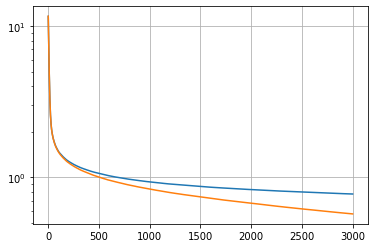

In [151]:
eval_results = model.evals_result_
#eval_results['l1']
l1 = eval_results["training"]["l1"]
valid = eval_results["valid_1"]["l1"]
plt.plot(valid)
plt.plot(l1)
plt.yscale('log')
#ax.set_yticks(np.linspace(100, 1000, 10))

plt.grid(True)

In [152]:
tmp = y_pred- y_val
tmp.describe()

count    212825.000000
mean     0.000603     
std      1.139225     
min     -47.624964    
25%     -0.519708     
50%      0.015584     
75%      0.539960     
max      24.959537    
Name: scalar_coupling_constant, dtype: float64

In [153]:
X_train.describe()

,atom_2,atom_3,atom_4,atom_5,atom_6,atom_7,atom_8,atom_9,atom_10,atom_11,atom_12,atom_13,atom_14,r_x_1,r_x_2,r_x_3,r_x_4,r_x_5,r_x_6,r_x_7,r_x_8,r_x_9,r_x_10,r_x_11,r_x_12,r_x_13,r_x_14,r_y_2,r_y_3,r_y_4,r_y_5,r_y_6,r_y_7,r_y_8,r_y_9,r_y_10,r_y_11,r_y_12,r_y_13,r_y_14,r_z_3,r_z_4,r_z_5,r_z_6,r_z_7,r_z_8,r_z_9,r_z_10,r_z_11,r_z_12,r_z_13,r_z_14,d_2_0,d_2_1,d_3_0,d_3_1,d_3_2,d_4_0,d_4_1,d_4_2,d_4_3,d_5_0,d_5_1,d_5_2,d_5_3,d_6_0,d_6_1,d_6_2,d_6_3,d_7_0,d_7_1,d_7_2,d_7_3,d_8_0,d_8_1,d_8_2,d_8_3,d_9_0,d_9_1,d_9_2,d_9_3,d_10_0,d_10_1,d_10_2,d_10_3,d_11_0,d_11_1,d_11_2,d_11_3,d_12_0,d_12_1,d_12_2,d_12_3,d_13_0,d_13_1,d_13_2,d_13_3,d_14_0,d_14_1,d_14_2,d_14_3
count,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,4.965910e+05,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000,496591.000000
mean,2.572099,4.717967,5.778039,2.688567,3.565210,4.022950,4.104883,4.122729,4.001216,3.799431,3.585135,3.369330,3.060206,-0.546448,-0.979297,-1.101733,-1.150712,-0.723283,-0.889793,-1.194948,-1.362521,-1.513894,-1.626870,-1.736397,-1.839030,-1.925946,-1.959729,1.083174,-0.697400,-0.728267,-1.042891,-1.043191,-0.937178,-0.906226,-0.900408,-0.899845,-0.958346,-1.067876,-1.187610,-1.264360,0.002383,-0.005293,-0.037969,2.421090e-03,0.018951,0.008870,0.003199,0.012047,0.022264,0.019315,0.019840,0.019518,1.878496,1.181593,2.075251,1.385117,2.069414,2.256265,1.603505,2.221700,2.187207,2.619830,2.306214,2.888720,2.459843,2.804622,2.445265,2.978219,2.515604,3.012589,2.555342,2.984595,2.603313,3.201296,2.708091,3.081654,2.741925,3.397339,2.878632,3.209511,2.881039,3.604386,3.081276,3.371280,3.081515,3.816858,3.292624,3.561771,3.276086,4.018905,3.494686,3.761085,3.453251,4.186962,3.666728,3.938507,3.589787,4.278828,3.775140,4.045308,3.678973
std,2.622686,2.590072,1.325203,2.573400,2.778234,2.736132,2.735758,2.739227,2.752049,2.773536,2.787885,2.792463,2.775051,0.003408,0.167704,0.288534,0.348077,0.745176,0.974404,1.117602,1.237348,1.306558,1.386677,1.456445,1.508524,1.569697,1.652949,0.173569,0.338367,0.648704,1.143748,1.158375,1.197240,1.274931,1.382599,1.488657,1.593102,1.679532,1.754571,1.821403,0.990995,1.100623,1.548254,1.605401e+00,1.640353,1.705848,1.796922,1.944516,2.087116,2.226564,2.343508,2.447050,0.173031,0.153180,0.273255,0.239494,0.287427,0.268314,0.281139,0.355088,0.411777,0.311087,0.252551,0.627075,0.883420,0.389577,0.312063,0.637424,0.901414,0.453869,0.381026,0.680618,0.909738,0.529942,0.471805,0.737047,0.949875,0.598839,0.557120,0.800457,0.986025,0.677281,0.636667,0.876675,1.023181,0.757174,0.714613,0.954516,1.062504,0.853301,0.808149,1.039921,1.127167,1.009044,0.948721,1.158950,1.237351,1.261956,1.170916,1.361296,1.415774
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,

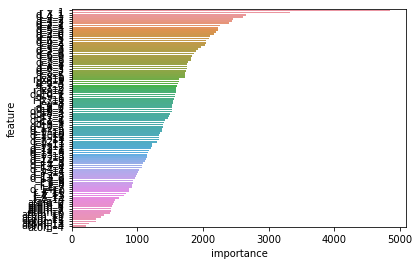

In [154]:
cols = list(X_train.columns)
#cols.remove('scalar_coupling_constant')
cols
df_importance = pd.DataFrame({'feature': cols, 'importance': model.feature_importances_})
sns.barplot(x="importance", y="feature", data=df_importance.sort_values('importance', ascending=False));

In [155]:
df_importance.sort_values('importance', ascending=False)

,feature,importance
13,r_x_1,4855
55,d_3_1,3321
58,d_4_1,2657
27,r_y_2,2617
60,d_4_3,2462
56,d_3_2,2446
53,d_2_1,2403
16,r_x_4,2261
62,d_5_1,2237
61,d_5_0,2222


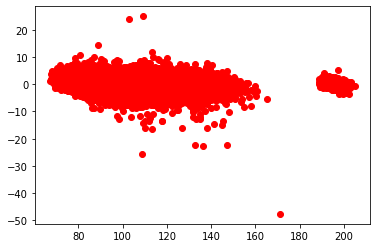

In [180]:
plt.plot(y_val, y_pred- y_val, 'ro')

In [175]:
#err = np.abs(y_pred- y_val)
import pandas as pd
dp = X_val
dp['err'] = pd.Series(np.abs(y_pred- y_val))
bigErr = dp[dp.err > 10]
#bigErr
#plt.plot(err, 'ro')

C:\ProgramFiles\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [181]:
dp.describe()

,atom_2,atom_3,atom_4,atom_5,atom_6,atom_7,atom_8,atom_9,atom_10,atom_11,atom_12,atom_13,atom_14,r_x_1,r_x_2,r_x_3,r_x_4,r_x_5,r_x_6,r_x_7,r_x_8,r_x_9,r_x_10,r_x_11,r_x_12,r_x_13,r_x_14,r_y_2,r_y_3,r_y_4,r_y_5,r_y_6,r_y_7,r_y_8,r_y_9,r_y_10,r_y_11,r_y_12,r_y_13,r_y_14,r_z_3,r_z_4,r_z_5,r_z_6,r_z_7,r_z_8,r_z_9,r_z_10,r_z_11,r_z_12,r_z_13,r_z_14,d_2_0,d_2_1,d_3_0,d_3_1,d_3_2,d_4_0,d_4_1,d_4_2,d_4_3,d_5_0,d_5_1,d_5_2,d_5_3,d_6_0,d_6_1,d_6_2,d_6_3,d_7_0,d_7_1,d_7_2,d_7_3,d_8_0,d_8_1,d_8_2,d_8_3,d_9_0,d_9_1,d_9_2,d_9_3,d_10_0,d_10_1,d_10_2,d_10_3,d_11_0,d_11_1,d_11_2,d_11_3,d_12_0,d_12_1,d_12_2,d_12_3,d_13_0,d_13_1,d_13_2,d_13_3,d_14_0,d_14_1,d_14_2,d_14_3,err
count,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,2.128250e+05,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,2.128250e+05,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,212825.000000,2.128250e+05
mean,2.571704,4.721151,5.774016,2.678567,3.552430,4.034625,4.112571,4.121386,4.005333,3.797712,3.580735,3.373255,3.084257,-0.546453,-0.979057,-1.101568,-1.150830,-0.720139,-0.889466,-1.196331,-1.359661,-1.515969,-1.626110,-1.734391,-1.843219,-1.926276,-1.954025,1.082886e+00,-0.697432,-0.730545,-1.046891,-1.046137,-0.932311,-0.901794,-0.897274,-0.897612,-0.957933,-1.061395,-1.188468,-1.254865,0.001000,-0.003886,-0.033579,2.256377e-03,0.021723,0.004583,0.004899,0.019299,0.019561,0.008092,0.015167,0.016881,1.878149,1.181241,2.075249,1.385225,2.069462,2.256424,1.603755,2.223019,2.185335,2.618729,2.306388,2.890788,2.459271,2.803367,2.443994,2.979051,2.512320,3.012651,2.554952,2.982055,2.604942,3.201472,2.709376,3.081403,2.744440,3.399179,2.879875,3.209803,2.882592,3.605575,3.083123,3.372375,3.082876,3.817777,3.294532,3.563295,3.278420,4.024856,3.500325,3.764591,3.460632,4.192391,3.672695,3.944624,3.597282,4.283636,3.782014,4.049682,3.690006,7.748113e-01
std,2.624643,2.590184,1.329989,2.569238,2.780522,2.731495,2.733697,2.737010,2.749699,2.776367,2.788320,2.793741,2.779643,0.003413,0.167466,0.288444,0.350762,0.745584,0.974068,1.119165,1.238127,1.308205,1.392396,1.460209,1.516273,1.575111,1.660868,1.734987e-01,0.338431,0.646391,1.143765,1.155865,1.197657,1.278089,1.383358,1.488609,1.596296,1.685266,1.757844,1.830294,0.991246,1.100063,1.546055,1.603422e+00,1.640610,1.709361,1.798336,1.945738,2.086969,2.226342,2.345863,2.452949,0.172629,0.152818,0.273263,0.239570,0.286909,0.269484,0.281702,0.354639,0.412933,0.310558,0.252498,0.627438,0.882244,0.388849,0.310984,0.634161,0.900645,0.454702,0.381259,0.679861,0.910697,0.531697,0.474231,0.738437,0.951689,0.600423,0.559561,0.800289,0.988607,0.680805,0.639543,0.878380,1.024981,0.759441,0.716217,0.955765,1.061848,0.853216,0.807664,1.037899,1.125153,1.007887,0.948041,1.156943,1.235543,1.259574,1.169092,1.359266,1.415127,8.351636e-01
min,1.00

In [176]:
stdErr = bigErr.std()

In [177]:
stdDp = dp.std()

In [178]:
 stdErr / stdDp

atom_2     0.867682
atom_3     0.428500
atom_4     1.991121
atom_5     1.087737
atom_6     1.075646
atom_7     1.044287
atom_8     1.058119
atom_9     1.080163
atom_10    1.005930
atom_11    1.053876
atom_12    1.020901
atom_13    0.975982
atom_14    0.846758
r_x_1      1.236588
r_x_2      1.131381
r_x_3      0.876858
r_x_4      1.303776
r_x_5      1.234489
r_x_6      1.136520
r_x_7      1.186300
r_x_8      1.101494
r_x_9      1.292062
r_x_10     1.097769
r_x_11     1.100504
r_x_12     1.093154
r_x_13     0.959200
r_x_14     1.080971
r_y_2      1.420017
r_y_3      1.685455
r_y_4      1.798211
r_y_5      1.423145
r_y_6      1.447954
r_y_7      1.051713
r_y_8      1.259072
r_y_9      1.316877
r_y_10     1.312099
r_y_11     1.157906
r_y_12     1.058580
r_y_13     1.103910
r_y_14     1.229550
r_z_3      0.832438
r_z_4      0.833920
r_z_5      0.764811
r_z_6      0.719930
r_z_7      0.860469
r_z_8      0.736111
r_z_9      0.620688
r_z_10     0.706727
r_z_11     0.584158
r_z_12     0.618848


In [160]:
tmp = dp[np.abs(dp.r_z_3) < 0.9]
tmp.describe()


,atom_2,atom_3,atom_4,atom_5,atom_6,atom_7,atom_8,atom_9,atom_10,atom_11,atom_12,atom_13,atom_14,r_x_1,r_x_2,r_x_3,r_x_4,r_x_5,r_x_6,r_x_7,r_x_8,r_x_9,r_x_10,r_x_11,r_x_12,r_x_13,r_x_14,r_y_2,r_y_3,r_y_4,r_y_5,r_y_6,r_y_7,r_y_8,r_y_9,r_y_10,r_y_11,r_y_12,r_y_13,r_y_14,r_z_3,r_z_4,r_z_5,r_z_6,r_z_7,r_z_8,r_z_9,r_z_10,r_z_11,r_z_12,r_z_13,r_z_14,d_2_0,d_2_1,d_3_0,d_3_1,d_3_2,d_4_0,d_4_1,d_4_2,d_4_3,d_5_0,d_5_1,d_5_2,d_5_3,d_6_0,d_6_1,d_6_2,d_6_3,d_7_0,d_7_1,d_7_2,d_7_3,d_8_0,d_8_1,d_8_2,d_8_3,d_9_0,d_9_1,d_9_2,d_9_3,d_10_0,d_10_1,d_10_2,d_10_3,d_11_0,d_11_1,d_11_2,d_11_3,d_12_0,d_12_1,d_12_2,d_12_3,d_13_0,d_13_1,d_13_2,d_13_3,d_14_0,d_14_1,d_14_2,d_14_3,err
count,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.00000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,4.912300e+04,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000,49123.000000
mean,4.416241,5.912526,4.710950,2.896525,3.840502,4.335179,4.25200,4.096309,3.911040,3.682328,3.391141,3.104757,2.689107,-0.543173,-1.156361,-1.339972,-1.234296,-0.912688,-1.228326,-1.674582,-1.871978,-1.979932,-2.032394,-2.188193,-2.298706,-2.339449,-2.288605,1.044891e+00,-1.041532,-0.615359,-1.109260,-1.034414,-0.803853,-0.763417,-0.724072,-0.734952,-0.803229,-0.908713,-0.994110,-1.017928,0.010659,-0.019110,-0.008721,-0.008896,-0.010914,-0.013845,-0.000310,0.004100,0.019884,0.022003,0.025005,0.025781,2.016989,1.250202,2.272748,1.519353,2.256176,2.476276,1.854508,2.248133,1.882945,2.755443,2.395502,2.893916,2.036695,2.979193,2.522053,2.916583,2.154977,3.247954,2.651917,2.856095,2.300944,3.462757,2.828270,2.973400,2.444897,3.684090,3.058908,3.157373,2.701127,3.895159,3.297726,3.371866,2.951900,4.110059,3.504818,3.560271,3.131392,4.276280,3.674208,3.728820,3.255339,4.341362,3.756814,3.816623,3.313524,4.272656,3.724440,3.782692,3.284724,0.904742
std,2.862653,1.391350,2.391767,2.681956,2.822863,2.680928,2.70364,2.759298,2.789718,2.808302,2.812123,2.801949,2.734659,0.004896,0.196936,0.460298,0.696575,1.022191,1.248447,1.277658,1.341180,1.433302,1.546872,1.612515,1.691181,1.784174,1.902386,2.831753e-01,0.324014,1.311640,1.505125,1.433509,1.406809,1.457395,1.606703,1.746599,1.872743,1.978489,2.053165,2.110724,0.596839,0.793701,1.085206,1.164079,1.310775,1.434971,1.601317,1.793199,1.878891,1.952089,2.006567,2.031561,0.173254,0.157275,0.368387,0.295919,0.275003,0.487302,0.507539,0.699085,0.716537,0.490844,0.347921,0.818473,0.874195,0.545305,0.388855,0.799218,0.818444,0.583420,0.477401,0.830905,0.835379,0.634168,0.579683,0.875590,0.897975,0.715820,0.660490,0.934840,0.917810,0.808572,0.738907,1.002833,0.949293,0.917621,0.841461,1.093135,1.000049,1.089833,0.996028,1.222278,1.114827,1.361522,1.231435,1.420815,1.294045,1.721692,1.544963,1.703368,1.536086,0.972764
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0

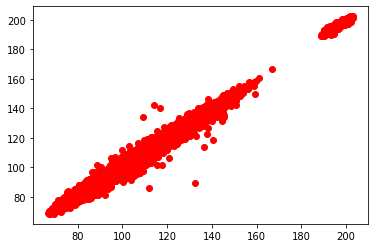

In [75]:
plt.plot(y_val, y_pred, 'ro')

In [76]:
fff

NameError: name 'fff' is not defined

In [ ]:
np.power(2,10)

## Submission Model


In [ ]:
def train_and_predict_for_one_coupling_type(coupling_type, submission, n_atoms, n_folds=3, n_splits=3, random_state=128):
    model_type =  'lgb' #lgb  cat
    print(f'*** Training Model for {coupling_type} ***')
    
    X_data, y_data = build_x_y_data(train_csv, coupling_type, n_atoms, False)
    columns = X_data.columns 
    X_test, _ = build_x_y_data(test_csv, coupling_type, n_atoms, True)
    y_pred = np.zeros(X_test.shape[0], dtype='float32')


    cv_score = 0
    
    if n_folds > n_splits:
        n_splits = n_folds
    
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    for fold, (train_index, val_index) in enumerate(kfold.split(X_data, y_data)):
        if fold >= n_folds:
            break

        #X_train, X_val = X_data[train_index], X_data[val_index]
        #y_train, y_val = y_data[train_index], y_data[val_index]
        X_train, X_val = X_data[columns].iloc[train_index], X_data[columns].iloc[val_index]
        y_train, y_val = y_data.iloc[train_index], y_data.iloc[val_index]

        model = ""
        categorical_features = [col for col in X_train if col.startswith('atom_')]
        if model_type == 'lgb':

            model = LGBMRegressor(**LGB_PARAMS, n_estimators=10000, n_jobs = -1)
            #model = LGBMRegressor(**LGB_PARAMS, n_estimators=6000, n_jobs = -1)
            model.fit(X_train, y_train, 
                eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric='mae',
                verbose=100, early_stopping_rounds=1000,
                     categorical_feature = categorical_features)
        
        if model_type == 'cat': 
            model = CatBoostRegressor(eval_metric='MAE', **CAT_PARAMS, loss_function='MAE')
            X_trainGlob = X_train
            model.fit(X_train, y_train, eval_set=((X_val, y_val)), 
                      cat_features = categorical_features,
                      use_best_model=True,
                      verbose=False)

        y_val_pred = model.predict(X_val)
        val_score = np.log(mean_absolute_error(y_val, y_val_pred))
        print(f'{coupling_type} Fold {fold}, logMAE: {val_score}')
        
        cv_score += val_score / n_folds
        y_pred += model.predict(X_test) / n_folds
        
    submission.loc[test_csv['type'] == coupling_type, 'scalar_coupling_constant'] = y_pred
    return cv_score

Let's build a separate model for each type of coupling. Dataset is split into 5 pieces and in this kernel we will use only 3 folds for speed up.

Main tuning parameter is the number of atoms. I took good numbers, but accuracy can be improved a bit by tuning them for each type.

In [ ]:
if False: 
    model_params = {
        '1JHC': 10,
        '1JHN': 7,    
        '2JHH': 9,
        '2JHN': 9,
        '2JHC': 9,
        '3JHH': 9,
        '3JHC': 10,
        '3JHN': 10
    }



Checking cross-validation scores for each type:

In [ ]:
N_FOLDS = 3
submission = submission_csv.copy()

cv_scores = {}
for coupling_type in model_params.keys():
    cv_score = train_and_predict_for_one_coupling_type(
        coupling_type, submission, n_atoms=model_params[coupling_type], n_folds=N_FOLDS)
    cv_scores[coupling_type] = cv_score

In [ ]:
pd.DataFrame({'type': list(cv_scores.keys()), 'cv_score': list(cv_scores.values())})

And cv mean score:

In [ ]:
np.mean(list(cv_scores.values()))

Sanity check for all cells to be filled with predictions:

In [ ]:
submission[submission['scalar_coupling_constant'] == 0].shape

In [ ]:
submission.head(10)

In [ ]:
submission.to_csv(f'{SUBMISSIONS_PATH}/submission.csv')

## a!!!